In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
from torchvision.transforms import ToTensor, Lambda, Compose, Resize, ToTensor

from transformers import AutoModel, AutoTokenizer

import matplotlib.pyplot as plt

from PIL import Image

import requests
import numpy as np

from collections import defaultdict
from abc import abstractmethod

import gc
import os
import random

from tqdm import tqdm

import traceback

device = "cuda" if torch.cuda.is_available() else "cpu"

# DATA

## Test Images

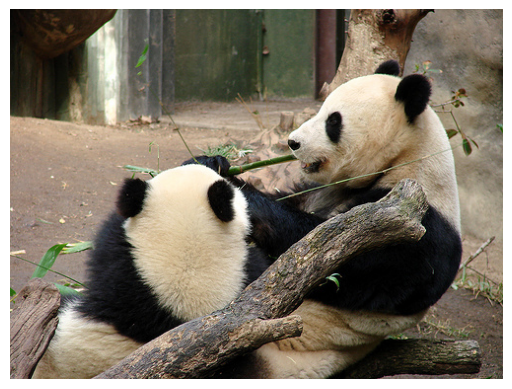

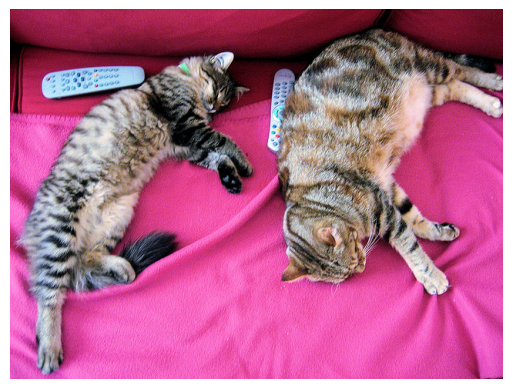

In [ ]:
image_panda = Image.open(requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02510455_giant_panda.JPEG", stream=True).raw)
plt.imshow(image_panda)
plt.axis('off')
plt.show()

image_cat = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)
plt.imshow(image_cat)
plt.axis('off')
plt.show()

test_imgs = [image_panda, image_cat]
gt_labels = ['a panda','a cat']

## Tiny-ImageNet

In [ ]:
!pip install -U datasets

In [ ]:
# load dataset
from datasets import load_dataset, load_dataset, get_dataset_split_names, get_dataset_infos

tiny_ds_name = 'zh-plus/tiny-imagenet'
get_dataset_split_names(tiny_ds_name)

['train', 'valid']

In [ ]:
ds_info = get_dataset_infos(tiny_ds_name)
tiny_ds_wnids = ds_info['default'].features['label'].names

tiny_ds_wnids[:5]

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']

In [ ]:
# load dataset labels
import json

imagenet_class_index = requests.get("https://raw.githubusercontent.com/raghakot/keras-vis/refs/heads/master/resources/imagenet_class_index.json", stream=True).json()
imagenet_class_index = {int(k):v for k,v in imagenet_class_index.items()}

rand_id = np.random.randint(low=0,high=len(imagenet_class_index))
print(f'Random class: \t [{rand_id}] {imagenet_class_index[rand_id][1]}')

Random class: 	 [773] saltshaker


In [ ]:
# class id mappings:

# WNID -> index
wnid_to_index = {v[0]: int(k) for k, v in imagenet_class_index.items()}

# index -> WNID
index_to_wnid = {int(k): v[0]  for k, v in imagenet_class_index.items()}

# num_label -> str_label
index_to_label = {int(k): ' '.join(v[1].split('_')) for k, v in imagenet_class_index.items()}

In [ ]:
# hardcoding labels for incorrect ones (see https://huggingface.co/datasets/zh-plus/tiny-imagenet/discussions/1)
hardcoded_labels = {}
hardcoded_labels['n02666347'] = 'n02666196'
hardcoded_labels['n03373237'] = 'n02190166'
hardcoded_labels['n04465666'] = 'n04465501'
hardcoded_labels['n04598010'] = 'n04597913'
hardcoded_labels['n07056680'] = 'n04067472'
hardcoded_labels['n07646821'] = 'n01855672'
hardcoded_labels['n07647870'] = 'n03250847'
hardcoded_labels['n07657664'] = 'n07579787'
hardcoded_labels['n07975909'] = 'n02206856'
hardcoded_labels['n08496334'] = 'n02730930'
hardcoded_labels['n08620881'] = 'n03976657'
hardcoded_labels['n08742578'] = 'n02085620'
hardcoded_labels['n12520864'] = 'n02906734'
hardcoded_labels['n13001041'] = 'n07734744'
hardcoded_labels['n13652335'] = 'n03804744'
hardcoded_labels['n13652994'] = 'n02999410'
hardcoded_labels['n13719102'] = 'n01945685'
hardcoded_labels['n14991210'] = 'n07747607'

In [ ]:
tiny_label_to_text = {}
for i, wnid in enumerate(tiny_ds_wnids):
  if wnid not in wnid_to_index.keys():
    wnid = hardcoded_labels[wnid]

  id = wnid_to_index[wnid]
  tiny_label_to_text[i] = index_to_label[id]

# tiny_label_to_text

In [ ]:
# MISALIGNMENT BETWEEN   a) TinyImageNet numerical labels and    b) ImageNet ones:
#   mapping from (a) to (b) via the class wnid

tinyImgN_label_to_ImgN_label = {}

for num_id, wn_id in enumerate(tiny_ds_wnids):
  if wn_id not in wnid_to_index.keys():
    wn_id = hardcoded_labels[wn_id]
  tinyImgN_label_to_ImgN_label[num_id] = wnid_to_index[wn_id]

# and opposite mapping: model prediction labels (ImageNet ones) to TinyImageNet numerical
imgN_label_to_tinyImgN_label = {v: k for k, v in tinyImgN_label_to_ImgN_label.items()}

In [ ]:
ds_preprocess = Compose([
    Resize((224, 224)),
    ToTensor(),
    ])

tiny_ds = load_dataset(tiny_ds_name, split='valid').with_format(type='torch', columns=['image', 'label'])

def dataset_transforms(examples):
    examples["image"] = [ds_preprocess(img.convert("RGB")) for img in examples["image"]]
    return examples
tiny_ds = tiny_ds.with_transform(dataset_transforms)

batch_size=32
dataloader = DataLoader(tiny_ds, batch_size=batch_size, shuffle=True, num_workers=2)

SHAPEs: torch.Size([32, 3, 224, 224]) torch.Size([32]) 



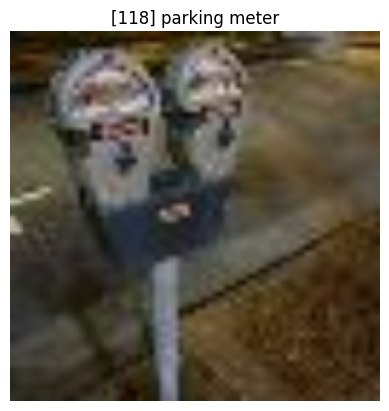

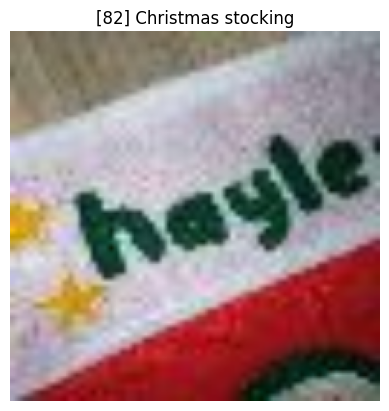

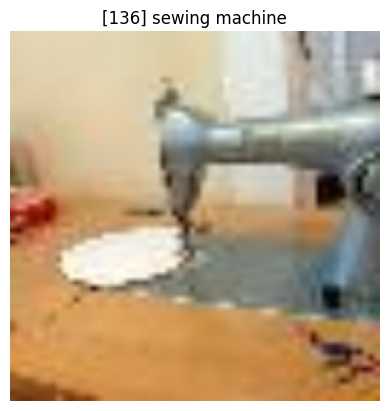

In [ ]:
# show 3 random imgs
for batch in dataloader:
  imgs = batch['image']
  labels = batch['label']
  print('SHAPEs:', imgs.shape, labels.shape, '\n')
  for i in range(3):
    plt.imshow(imgs[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'[{labels[i]}] {tiny_label_to_text[labels[i].item()]}')
    plt.show()
  break

In [ ]:
# generate captions from all dataset classes

all_captions = []
for label in tiny_label_to_text.values():
  all_captions.append(f'a picture of a {label}')

start_id = np.random.randint(low=0,high=len(all_captions)-5)
all_captions[start_id:start_id+5]

['a picture of a Persian cat',
 'a picture of a Egyptian cat',
 'a picture of a cougar',
 'a picture of a lion',
 'a picture of a brown bear']

# MODELS

In [ ]:
run_simple_model_tests = True

In [ ]:
test_images = None
test_labels = None

if run_simple_model_tests:
  for batch in dataloader:
    test_images, test_labels = batch['image'], batch['label']
    break

## CLIP
 - ResNet50
 - ViT-B/16

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oox7asjw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oox7asjw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
if run_simple_model_tests:
  av_models = clip.available_models()
  tested_model_names = []
  for model_name in ['RN50', 'RN101', 'ViT-B/16', 'ViT-L/14']:
  # for model_name in ['RN50']:
    if model_name in av_models:
      tested_model_names.append(model_name)

  print(f'TESTING CLIP MODELS: {tested_model_names}')

In [ ]:
if run_simple_model_tests:
  for model_name in tested_model_names:
    print(f'Model: {model_name}')
    model, preprocess = clip.load(model_name, device=device)

    for test_img, gt_label in zip(test_imgs, gt_labels):
      image = preprocess(test_img).unsqueeze(0).to(device)
      labels = ["a diagram", "a dog", "a cat", 'a panda']
      text = clip.tokenize(labels).to(device)

      with torch.no_grad():
          logits_per_image, logits_per_text = model(image, text)
          probs = logits_per_image.softmax(dim=-1).cpu().numpy()

      print(f'GT: {gt_label}')
      print(f"PRED: {labels[np.argmax(probs)]} [{np.max(probs)}], probs: {['{:.3f}'.format(prob) for prob in probs[0]]}")
    print('\n')

## Perception Encoder

https://colab.research.google.com/github/facebookresearch/perception_models/blob/main/apps/pe/docs/pe_demo.ipynb#scrollTo=38f80aa1

In [ ]:
import os, sys
import torch
import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/facebookresearch/perception_models.git
    !pip install decord
    !pip install ftfy
    sys.path.append('./perception_models')
    os.chdir('./perception_models')
else:
    sys.path.append('../../../')
import decord

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms

os.chdir('..')

Running in Colab.
fatal: destination path 'perception_models' already exists and is not an empty directory.


In [ ]:
if run_simple_model_tests:
  model_name = 'PE-Core-B16-224'

  model = pe.CLIP.from_config(model_name, pretrained=True)
  model = model.to(device)

  preprocess = transforms.get_image_transform(model.image_size)
  tokenizer = transforms.get_text_tokenizer(model.context_length)

In [ ]:
if run_simple_model_tests:
  labels = ["a diagram", "a dog", "a cat", 'a panda']
  text = tokenizer(labels).to(device)

  for test_img, gt_label in zip(test_imgs, gt_labels):
    image = preprocess(test_img).unsqueeze(0).to(device)
    with torch.no_grad():
      image_features, text_features, logit_scale = model(image, text)
      text_probs = (logit_scale * image_features @ text_features.T).softmax(dim=-1).cpu()[0]

    print("Captions:", labels)
    print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))
    print(f"This image is about {labels[text_probs.argmax()]}")
    print('\n')

## ALIGN

In [ ]:
if run_simple_model_tests:

  model = AutoModel.from_pretrained("kakaobrain/align-base").to(device)
  tokenizer = AutoTokenizer.from_pretrained("kakaobrain/align-base")

  align_preprocess = T.Compose([
      T.Resize((346, 346), interpolation=T.InterpolationMode.BILINEAR),
      T.CenterCrop((289, 289)),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])

  image_inputs = align_preprocess(test_images).to(device)


  lab_to_id = {lab:i for  i, lab in enumerate(set([tiny_label_to_text[label.item()] for label in test_labels]))}
  gt_n_labels = torch.tensor([lab_to_id[gt_lab] for gt_lab in [tiny_label_to_text[label.item()] for label in test_labels]])
  class_names = lab_to_id.keys()

  prompts = [f"a photo of a {name}" for name in class_names]
  text_inputs = tokenizer(prompts, padding="max_length", return_tensors="pt").to(device)

  with torch.no_grad():
      img_outputs = model.get_image_features(image_inputs)
      text_outputs = model.get_text_features(**text_inputs)

  img_outputs /= img_outputs.norm(dim=-1, keepdim=True)
  text_outputs /= text_outputs.norm(dim=-1, keepdim=True)

  similarity = img_outputs @ text_outputs.T

  print((similarity.argmax(dim=1).cpu() == gt_n_labels.cpu()).float().mean())

## SigLIP

In [ ]:
if run_simple_model_tests:

  model = AutoModel.from_pretrained("google/siglip-base-patch16-224").to(device)
  tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")

  siglip_preprocess = T.Compose([
      T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])
  image_inputs = siglip_preprocess(test_images).to(device)

  lab_to_id = {lab:i for  i, lab in enumerate(set([tiny_label_to_text[label.item()] for label in test_labels]))}
  gt_n_labels = torch.tensor([lab_to_id[gt_lab] for gt_lab in [tiny_label_to_text[label.item()] for label in test_labels]])
  class_names = lab_to_id.keys()

  prompts = [f"a photo of a {name}" for name in class_names]
  text_inputs = tokenizer(prompts, padding="max_length", return_tensors="pt").to(device)

  with torch.no_grad():
      img_outputs = model.get_image_features(image_inputs)
      text_outputs = model.get_text_features(**text_inputs)

  img_outputs /= img_outputs.norm(dim=-1, keepdim=True)
  text_outputs /= text_outputs.norm(dim=-1, keepdim=True)

  similarity = img_outputs @ text_outputs.T

  print((similarity.argmax(dim=1).cpu() == gt_n_labels.cpu()).float().mean())

## Flava

In [ ]:
if run_simple_model_tests:
  model = AutoModel.from_pretrained("facebook/flava-full")
  tokenizer = AutoTokenizer.from_pretrained("facebook/flava-full")

  model.eval()

  lab_to_id = {lab:i for  i, lab in enumerate(set([tiny_label_to_text[label.item()] for label in test_labels]))}
  gt_n_labels = torch.tensor([lab_to_id[gt_lab] for gt_lab in [tiny_label_to_text[label.item()] for label in test_labels]])
  class_names = lab_to_id.keys()

  prompts = [f"a photo of a {name}" for name in class_names]
  text_inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

  tensor_preprocess = T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True),
        T.CenterCrop(224),
        T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
      ])

  image_inputs = tensor_preprocess(test_images)

  with torch.no_grad():
      image_outputs = model.get_image_features(image_inputs)
      text_outputs = model.get_text_features(**text_inputs)
  image_outputs.shape, text_outputs.shape

  image_outputs /= image_outputs.norm(dim=-1, keepdim=True)
  text_outputs /= text_outputs.norm(dim=-1, keepdim=True)

  # extract class token
  image_embeddings = image_outputs[:, 0, :]
  text_embeddings = text_outputs[:, 0, :]
  image_embeddings.shape, text_embeddings.shape

  # compute similarities
  sims = image_embeddings @ text_embeddings.T
  print((sims.argmax(dim=1) == gt_n_labels).float().mean())

## My Model Wrapper

In [ ]:
class ModelWrapper(nn.Module):
  def __init__(self, model, tokenizer, device):
    super().__init__()
    self.model:nn.Module = model
    self.tokenizer = tokenizer
    self.captions = None
    self.text_features = None
    self.device = device

    self.tensor_preprocess = T.Compose([])

  def forward(self, images, captions, return_to_cpu=True):
    are_text_feats_null = self.text_features is None
    with torch.no_grad():
      if are_text_feats_null:
        self.text_features = self.tokenize(captions)
        self.text_features.requires_grad = False

      self.text_features = self.text_features.to(self.device)

      if are_text_feats_null:
        self.text_features = self.encode_text(self.text_features)

    img_feats = self.encode_images(images)

    similarity = img_feats @ self.text_features.T

    self.text_features = self.text_features.detach().to('cpu')
    return similarity.cpu() if return_to_cpu else similarity

  def set_eval(self):
    self.model.eval()

  def move_to_device(self, device):
    self.model = self.model.to(device)

  def zero_grad(self):
    self.model.zero_grad()

  def predict(self, x, captions):
    with torch.no_grad(), torch.amp.autocast('cuda'):
      similarity = self.forward(x, captions)
    return similarity.argmax(dim=1)

  def preprocess(self, x):
    return self.tensor_preprocess(x)

  def encode_images(self, images):
    images = self.preprocess(images).to(self.device)
    img_feats = self.extract_img_feats(images)
    return img_feats / img_feats.norm(dim=-1, keepdim=True)

  def tokenize(self, x):
    return self.tokenizer(x)

  def encode_text(self, text):
    text_feats = self.extract_text_feats(text)
    return text_feats / text_feats.norm(dim=-1, keepdim=True)

  def extract_text_feats(self, text):
    return self.model.encode_text(text)

  def extract_img_feats(self, images):
    return self.model.encode_image(images)

class MyClipModel(ModelWrapper):
  def __init__(self, model, tokenizer, device):
    super().__init__(model, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
      T.CenterCrop(224),
      T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                  std=[0.26862954, 0.26130258, 0.27577711])])

class MyPeModel(ModelWrapper):
  def __init__(self, model, tokenizer, device):
    super().__init__(model, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize(224, interpolation=T.InterpolationMode.BILINEAR),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

class MyFlavaModel(ModelWrapper):
  def __init__(self, model, tokenizer, device):
    super().__init__(model, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC, antialias=True),
      T.CenterCrop(224),
      T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])])

  def tokenize(self, x):
    return self.tokenizer(x, return_tensors="pt", padding=True, truncation=True)

  def extract_text_feats(self, text):
    return self.model.get_text_features(**text)[:, 0, :]

  def extract_img_feats(self, images):
    return self.model.get_image_features(images)[:, 0, :]

class MyAlignModel(ModelWrapper):
  def __init__(self, model, tokenizer, device):
    super().__init__(model, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize((346, 346), interpolation=T.InterpolationMode.BILINEAR),
      T.CenterCrop((289, 289)),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

  def tokenize(self, x):
    return self.tokenizer(x, return_tensors="pt", padding=True, truncation=True)

  def extract_text_feats(self, text):
    return self.model.get_text_features(**text)

  def extract_img_feats(self, images):
    return self.model.get_image_features(images)

class MySiglipModel(ModelWrapper):
  def __init__(self, model, tokenizer, device):
    super().__init__(model, tokenizer, device)
    self.tensor_preprocess = T.Compose([
      T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
      T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

  def tokenize(self, x):
    return self.tokenizer(x, return_tensors="pt", padding=True, truncation=True)

  def extract_text_feats(self, text):
    return self.model.get_text_features(**text)

  def extract_img_feats(self, images):
    return self.model.get_image_features(images)

# ATTACKS

In [ ]:
class Attack():
  """
  Base class for all adversarial attacks.

  Args:
      epsilon: The maximum perturbation allowed for the attack
      device: The device to use for computations
  """
  def __init__(self, epsilon, device):
    self.attack_name='attack' # Base attack name
    self.epsilon=epsilon
    self.device=device

  @abstractmethod
  def get_name(self):
    """
    Returns the name of the attack.
    """
    return self.attack_name

  @abstractmethod
  def __call__(self, model, images, gt_labels, captions):
    """
    Performs the adversarial attack on the given model and images.

    Args:
        model: The target model to attack.
        images: The input images.
        labels: The true labels of the images.

    Returns:
        perturbed_images: Adversarially perturbed images
        perturbed_predictions: Predictions for the perturbed images
    """
    pass

## FGSM

In [ ]:
class FGSM(Attack):
  def __init__(self, epsilon=0.01, device='cuda'):
    super().__init__(epsilon, device)
    self.attack_name=f'FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions, iterations=1, use_momentum=False, decay_factor=0.9, use_transl_invariant_attack=False):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    gt_labels = gt_labels.to(self.device)

    # initialize images and move to device
    perturbed_images = images.clone().detach().to(self.device)

    alpha = self.epsilon / iterations
    perturbation = torch.zeros_like(perturbed_images, device=self.device)

    for _ in range(iterations):
      # enable gradients
      perturbed_images.requires_grad_(True)

      # forward pass: compute model outputs
      outputs = model(perturbed_images, captions, return_to_cpu=False)
      loss = F.cross_entropy(outputs, gt_labels)

      # backward pass: compute gradients
      model.zero_grad()
      loss.backward()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        # apply smoothing if using the translation-invariant attack
        if use_transl_invariant_attack:
          perturbed_images_grad = self.apply_smoothing(perturbed_images.grad)
        else:
          perturbed_images_grad = perturbed_images.grad

        # compute pertubation (w/ or w/o momentum)
        if use_momentum:
          perturbation = decay_factor * perturbation + (perturbed_images_grad / (torch.norm(perturbed_images_grad, p=1) + 1e-8))
        else:
          perturbation = perturbed_images_grad

        # apply perturbation and clamp in valid pixel range
        torch.clamp(perturbed_images + alpha * torch.sign(perturbation) - images, -self.epsilon, self.epsilon, out=perturbation)
        perturbed_images = torch.clamp(images + perturbation, 0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

### FGSM Variants

In [ ]:
class IFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.attack_name=f'I_FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=False)


class MIFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, decay_factor=0.9, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.decay_factor = decay_factor
    self.attack_name=f'MI_FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=True, decay_factor=self.decay_factor)


class TIFGSM(FGSM):
  def __init__(self, iterations=10, epsilon=0.01, kernel_size=15, sigma=3, channels=3, use_momentum=False, decay_factor=0.9, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.use_momentum = use_momentum
    self.decay_factor = decay_factor
    self.kernel = self.__get_gaussian_kernel(kernel_size, sigma, channels)
    self.attack_name='TI_' + ('M_' if use_momentum else '') + ('I_' if iterations > 1 else '') + f'FGSM-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    return super().__call__(model, images, gt_labels, captions, iterations=self.iterations, use_momentum=self.use_momentum, decay_factor=self.decay_factor, use_transl_invariant_attack=True)

  def __get_gaussian_kernel(self, kernel_size, sigma, channels):
    # 1d gaussian
    x = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
    gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
    gauss /= gauss.sum()

    # 2d gaussian
    gauss2d = torch.outer(gauss, gauss)
    gauss2d /= gauss2d.sum()

    # expand to channels
    kernel = gauss2d.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)
    return kernel.to(self.device)

  def apply_smoothing(self, perturbation):
    kernel = self.kernel.to(perturbation.device)
    padding = (self.kernel.shape[-1] - 1) // 2
    return F.conv2d(perturbation, kernel, padding=padding, groups=perturbation.shape[1])

## PGD

In [ ]:
class PGD(Attack):
  def __init__(self, iterations=10, epsilon=1e-2, device='cuda'):
    super().__init__(epsilon, device)
    self.alpha = epsilon / iterations
    self.iterations = iterations
    self.attack_name=f'PGD-{self.epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    gt_labels = gt_labels.to(self.device)

    # initialize images: enable gradients and move to device
    perturbed_images = images.clone().detach()

    # random initialization in epsilon-sphere
    with torch.no_grad():
      perturbed_images += torch.FloatTensor(perturbed_images.shape).uniform_(-self.epsilon, self.epsilon).to(self.device)
      perturbed_images.clamp_(0, 1)

    # attack loop
    for _ in range(self.iterations):
      # enable gradients
      perturbed_images.requires_grad_(True)

      # forward pass: compute model outputs
      outputs = model(perturbed_images, captions, return_to_cpu=False)
      loss = F.cross_entropy(outputs, gt_labels)

      # backward pass: compute gradients
      model.zero_grad()
      loss.backward()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        perturbation = self.alpha * torch.sign(perturbed_images.grad)
        perturbation = torch.clamp(perturbation, -self.epsilon, self.epsilon)

        # apply perturbation and clamp in valid pixel range
        perturbed_images = torch.clamp(perturbed_images + perturbation, 0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

## Embedding Space Disruption

In [ ]:
class EmbeddingSpaceDisruption(Attack):
  def __init__(self, epsilon=0.01, iterations=10, target_last_layer=True, target_layer=-1, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.target_last_layer = target_last_layer
    self.target_layer = target_layer
    self.embedding = None
    self.attack_name=f'EmbeddingSpaceDisruption-{self.epsilon}'

  def __hook(self, module, input, output):
      self.embedding = output

  def __set_hook(self, model):
    if not self.target_last_layer and self.target_layer > 0:
      if hasattr(model.model, 'visual'):
        if hasattr(model.model.visual, 'transformer'):
          if not self.target_last_layer:
            if self.target_layer < len(model.model.visual.transformer.resblocks) - 1:
              model.model.visual.transformer.resblocks[self.target_layer].register_forward_hook(self.__hook)
            else:
              self.target_last_layer = True
    else:
      self.target_last_layer = True
      self.target_layer = -1

  def __call__(self, model, images, gt_labels, captions):

    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)
    images = images.to(self.device)

    # initialize images and enable gradients
    perturbed_images = (images + torch.randn_like(images) * 0.01).clamp_(0, 1).requires_grad_(True)

    # get clean embeddings
    with torch.no_grad():
      self.__set_hook(model)
      final_embs = model.encode_images(perturbed_images)
      e_gt = final_embs.detach() if self.target_last_layer else self.embedding.detach()

    optimizer = torch.optim.AdamW([perturbed_images], lr=0.01)
    scaler = torch.amp.GradScaler(device=self.device)

    # attack loop
    for _ in range(self.iterations):
      optimizer.zero_grad()

      # forward + loss (l2 distance between GT and Adv embeddings)
      with torch.amp.autocast(device_type='cuda'):
        final_embs = model.encode_images(perturbed_images)
        e_adv = final_embs if self.target_last_layer else self.embedding
        loss = -torch.norm(e_gt - e_adv, p=2)

      # backward pass and perform update
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # compute perturbation using the sign of the gradients
      with torch.no_grad():
        perturbed_images.data = (images + torch.clamp((perturbed_images - images), -self.epsilon, self.epsilon)).clamp_(0, 1)

    with torch.no_grad():
      # get final predictions for the perturbed images
      perturbed_predictions = model.predict(perturbed_images, captions)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()
    model.move_to_device('cpu')

    return perturbed_images, perturbed_predictions

## UAP

In [ ]:
class UAP(Attack):
  def __init__(self, epsilon=0.01, iterations=1000, perturbation_shape=(3,224,224), device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.perturbation_shape = perturbation_shape
    self.attack_name = f'UAP-{epsilon}'

  def __call__(self, model, images, gt_labels, captions):
    pass

  def __call__(self, model, dataloader, captions, log_every_k=100):
    # move model and data to device
    model.set_eval()
    model.move_to_device(self.device)

    # initialize perturbation
    uaps = torch.zeros(self.perturbation_shape, device=self.device, requires_grad=True)

    # initialize optimizer
    optimizer = optim.Adam([uaps], lr=0.001)

    # vars for attack statistics
    tot_attacks = 0
    tot_success = 0
    temp_attacks = 0
    temp_success = 0

    tot_iterations = min(self.iterations, len(dataloader))
    for batch_id, batch in enumerate(dataloader):

      # move data to device
      images, labels = batch['image'], batch['label']
      images = images.to(self.device)
      labels = labels.to(self.device)

      perturbed_imgs = torch.clamp(images + uaps, 0, 1)

      # forward pass
      predictions = model(perturbed_imgs, captions, return_to_cpu=False)

      # loss + backward pass
      loss = -F.cross_entropy(predictions, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        uaps.clamp_(-self.epsilon, self.epsilon)

      # update attack statistics
      tot_attacks += predictions.shape[0]
      temp_attacks += predictions.shape[0]
      success = sum(predictions.argmax(1)!=labels).item()
      tot_success += success
      temp_success += success

      # log attack success
      if (batch_id%log_every_k)==0:
        print(f'{batch_id//log_every_k}/{tot_iterations//log_every_k} \t ASR={(tot_success/tot_attacks):.3f} \t ({tot_success}/{tot_attacks}) \t (+ {(temp_success/temp_attacks):.3f})')
        temp_attacks = 0
        temp_success = 0

      if batch_id == tot_iterations:
        break

    return uaps.detach()

## Ensemble

In [ ]:
class Ensemble(Attack):
  def __init__(self, epsilon=0.01, iterations=10, decay_factor=0.9, kernel_size=5, sigma=1, channels=3, device='cuda'):
    super().__init__(epsilon, device)
    self.iterations = iterations
    self.decay_factor = decay_factor
    self.kernel = self.__get_gaussian_kernel(kernel_size, sigma, channels)
    self.attack_name=f'Ensemble-(TI-MI-FGSM)-{self.epsilon}'

  def __call__(self, model_names, images, gt_labels, captions):
    gt_labels = gt_labels.to(self.device)

    # initialize images and move to device
    perturbed_images = images.clone().detach().to(self.device)

    alpha = self.epsilon / self.iterations
    perturbation = torch.zeros_like(perturbed_images, device=self.device)

    for _ in range(self.iterations):
      # enable gradients
      perturbed_images.requires_grad_(True)

      ensemble_grad = 0

      for model_name in model_names:
        # load current source model
        model = load_model(model_name)
        model.set_eval()

        # move model to device
        model.move_to_device(self.device)

        model.zero_grad()

        # forward pass: compute model outputs
        outputs = model(perturbed_images, captions, return_to_cpu=False)

        # compute loss
        loss = F.cross_entropy(outputs, gt_labels)

        # backward pass: compute gradients
        loss.backward()

        # apply smoothing for translation-invariant attack
        with torch.no_grad():
          grad = self.apply_smoothing(perturbed_images.grad.detach())

        ensemble_grad += grad

        # # move model back to cpu
        model.move_to_device('cpu')
        del model
        torch.cuda.empty_cache()
        gc.collect()

      # average over all models
      ensemble_grad /= len(model_names)

      # compute perturbation w/ momentum
      with torch.no_grad():
        perturbation = self.decay_factor * perturbation + (ensemble_grad / (torch.norm(ensemble_grad, p=1) + 1e-8))

        # apply perturbation and clamp in valid pixel range
        torch.clamp(perturbed_images + alpha * torch.sign(perturbation) - images, -self.epsilon, self.epsilon, out=perturbation)
        perturbed_images = torch.clamp(images + perturbation, 0, 1)

    # move results back to CPU for return
    perturbed_images = perturbed_images.detach().cpu()

    return perturbed_images

  def __get_gaussian_kernel(self, kernel_size, sigma, channels):
    # 1d gaussian
    x = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
    gauss = torch.exp(-x.pow(2) / (2 * sigma ** 2))
    gauss /= gauss.sum()

    # 2d gaussian
    gauss2d = torch.outer(gauss, gauss)
    gauss2d /= gauss2d.sum()

    # expand to channels
    kernel = gauss2d.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)
    return kernel.to(self.device)

  def apply_smoothing(self, perturbation):
    kernel = self.kernel.to(perturbation.device)
    padding = (self.kernel.shape[-1] - 1) // 2
    return F.conv2d(perturbation, kernel, padding=padding, groups=perturbation.shape[1])

# Adversarial tests

### Support Methods

In [ ]:
def reset_gpu():
  import gc
  gc.collect()
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [ ]:
def plot_clean_and_adv_img(clean_img, gt_label, adv_img, adv_pred):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].imshow(clean_img.permute(1,2,0))
  axes[0].set_title(f'GT: [{gt_label}]  {tiny_label_to_text[gt_label]}')
  axes[0].axis("off")
  axes[1].imshow(adv_img.permute(1,2,0))
  axes[1].set_title(f'Predicted: [{adv_pred}] {tiny_label_to_text[adv_pred]}')
  axes[1].axis("off")
  plt.show()

In [ ]:
def get_successfully_classified(model, images, labels):
  model.move_to_device(device)
  images = images.to(device)
  preds = model.predict(images, all_captions)
  correct = preds.cpu()==labels.cpu()
  return images[correct], labels[correct]

In [ ]:
# dump string in csv file
with open('results.csv', 'w') as f:
  f.write('attack_name,surr_model,target_model,tot_attacks,tot_success,asr\n')

def add_csv_row(attack_name, surr_model, target_model, tot_attacks, tot_success, file_path='results.csv'):
  if os.path.exists(file_path):
    with open(file_path, 'a') as f:
      f.write(f'{attack_name},{surr_model},{target_model},{tot_attacks},{tot_success},{tot_success/tot_attacks}\n')

In [ ]:
complete_model_names = {'rn':'RN50', 'vit':'ViT-B/16', 'align':'kakaobrain/align-base',  'siglip':'google/siglip-base-patch16-224', 'flava':'facebook/flava-full', 'pe-core':'PE-Core-B16-224'}

# load and return model in custom wrapper
def load_model(model_name):
  if model_name in ['rn', 'vit']:
    clip_model, _ = clip.load(complete_model_names[model_name])
    return MyClipModel(clip_model, clip.tokenize, device=device)

  elif model_name == 'pe-core':
    pe_model = pe.CLIP.from_config(complete_model_names[model_name], pretrained=True)
    pe_tokenizer = transforms.get_text_tokenizer(pe_model.context_length)
    return MyPeModel(pe_model, pe_tokenizer, device=device)

  elif model_name == 'flava':
    model = AutoModel.from_pretrained(complete_model_names[model_name])
    tokenizer = AutoTokenizer.from_pretrained(complete_model_names[model_name])
    return MyFlavaModel(model, tokenizer, device=device)

  elif model_name == 'align':
    model = AutoModel.from_pretrained(complete_model_names[model_name])
    tokenizer = AutoTokenizer.from_pretrained(complete_model_names[model_name])
    return MyAlignModel(model, tokenizer, device=device)

  elif model_name == 'siglip':
    model = AutoModel.from_pretrained(complete_model_names[model_name])
    tokenizer = AutoTokenizer.from_pretrained(complete_model_names[model_name])
    return MySiglipModel(model, tokenizer, device=device)

  else:
    print(f'NO MODEL WITH NAME \'{model_name}\'')
    return

In [ ]:
# compute model parameter complexity (i.e. model size)
def compute_model_size(model):
  size_model = 0
  for param in model.parameters():
    if param.data.is_floating_point():
      size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
      size_model += param.numel() * torch.iinfo(param.data.dtype).bits
  print(f"model size: {size_model / 8e6:.2f} / MB")


# pre-download all models
model_names = ['align', 'siglip', 'pe-core', 'flava', 'rn', 'vit']
for model_name in model_names:
  print(model_name)
  model = load_model(model_name)
  print('\t', end='')
  compute_model_size(model)
  del model
  torch.cuda.empty_cache()
  gc.collect()
  print()

align
	model size: 688.47 / MB

siglip
	model size: 812.62 / MB

pe-core
Missing keys for loading model: []
Unexpected keys for loading model: []
	model size: 1790.64 / MB

flava
	model size: 965.43 / MB

rn
	model size: 255.05 / MB

vit
	model size: 350.35 / MB



### Transfer

In [ ]:
reset_gpu()

# assess each model's robustness with 500 test images each
tot_images_for_eval = 500

# FGSM variants, PGD, and EmbeddingSpaceDisruption attacks with defined budget
epsilon = 4./255
attacks = [
    FGSM(epsilon=epsilon, device=device),
    IFGSM(epsilon=epsilon, iterations=10, device=device),
    MIFGSM(epsilon=epsilon, iterations=10, decay_factor=0.9, device=device),
    TIFGSM(epsilon=epsilon, iterations=10, kernel_size=5, sigma=1, use_momentum=True, decay_factor=0.9, device=device),
    PGD(epsilon=epsilon, iterations=20, device=device),
    EmbeddingSpaceDisruption(epsilon=epsilon, iterations=250, target_last_layer=True, device=device)
    ]

model_names = ['align', 'siglip', 'pe-core', 'flava', 'rn', 'vit']

for attack in attacks:
  print(f'ATTACK: {attack.get_name()}\n ===============================\n')

  # loop through all source models
  for surr_model_name in model_names:
    print(f'SURROGATE: {surr_model_name}\n -------------------------------')

    # load source model
    surr_model = load_model(surr_model_name)
    surr_model.set_eval()

    # attack result stats for each (target) model
    tot_attacks = torch.zeros(len(model_names))
    tot_success = torch.zeros(len(model_names))

    # create attack's progress bar, considering all target models given the considered source model (i.e. #_models - 1)
    progress_bar = tqdm(desc=f'Progress ({surr_model_name})', total=(len(model_names)-1)*tot_images_for_eval)
    for batch_id, batch in enumerate(dataloader):

      # break if already performed specified number of attacks
      if torch.all(tot_attacks>=tot_images_for_eval).item():
        break

      # move data to device
      images, labels = batch['image'].to(device), batch['label'].to(device)

      # perform attack with given source model
      adv_imgs, adv_preds = attack(surr_model, images, labels, all_captions)

      # move source model back to CPU
      surr_model.move_to_device('cpu')

      # loop through all target models
      for targ_model_id, targ_model_name in enumerate(model_names):
        # skip target model if already performed specified number of attacks with it
        if tot_attacks[targ_model_id] >= tot_images_for_eval:
          continue

        # skip white-box case (source equals to target)
        if targ_model_name == surr_model_name:
          # set # of performed attacks in white-box case to max, for simplicity
          if tot_attacks[targ_model_id] == 0:
            tot_attacks[targ_model_id] = tot_images_for_eval
          continue

        # load target model and move to device
        targ_model = load_model(targ_model_name)
        targ_model.set_eval()
        targ_model.move_to_device(device)

        # only test target model on images correctly classified when clean
        successfully_predicted = targ_model.predict(images, all_captions) == labels.cpu()

        # skip and delete model if no successfully classified images are found
        if successfully_predicted.sum()==0:
          targ_model.move_to_device('cpu')
          del targ_model
          continue

        # get perturbed images relative to successfully classified ones when clean
        images_for_target, labels_for_target = adv_imgs[successfully_predicted], labels[successfully_predicted]

        # get target model's predictions
        attack_success = targ_model.predict(images_for_target, all_captions) != labels_for_target.cpu()

        # update attack stats
        tot_attacks[targ_model_id] += len(attack_success)
        tot_success[targ_model_id] += attack_success.float().sum().item()

        # delete target model
        targ_model.move_to_device('cpu')
        del targ_model

        # get value for progress bar update (to avoid going over 100%)
        val_for_progressbar_update = len(attack_success)
        if tot_attacks[targ_model_id] > tot_images_for_eval:
          val_for_progressbar_update = int((tot_images_for_eval - (tot_attacks[targ_model_id] - val_for_progressbar_update)).item())

        # update progress bar with found value
        progress_bar.update(val_for_progressbar_update)

    # close progress bar
    progress_bar.close()

    # delte source model
    del surr_model
    torch.cuda.empty_cache()
    gc.collect()

    # print final results on target models
    for targ_model_id, targ_model_name in enumerate(model_names):
      if targ_model_name == surr_model_name:
        continue
      asr = int(tot_success[targ_model_id])/tot_attacks[targ_model_id]
      print(f'{targ_model_name}:\t asr={asr:.5f}  ({int(tot_success[targ_model_id])}/{tot_attacks[targ_model_id]})')
      add_csv_row(attack_name=attack.get_name(), surr_model=surr_model_name, target_model=targ_model_name, tot_attacks=tot_attacks[targ_model_id], tot_success=tot_success[targ_model_id])
    print('\n')

  reset_gpu()

### UAPs

In [ ]:
reset_gpu()

# UAP attack with defined budget
attack = UAP(epsilon=4./255, device=device)

model_names = ['align', 'siglip', 'pe-core', 'flava', 'rn', 'vit']

# assess each model's robustness with 500 test images each
tot_images_for_eval = 500

print(f'Attack: {attack.get_name()}\n\n')

# loop through all source models
for surr_model_name in model_names:
  print(f'SURROGATE {surr_model_name}\n ===============================')

  # load source model
  surr_model = load_model(surr_model_name)
  surr_model.set_eval()

  # perform attack
  uaps = attack(surr_model, dataloader=dataloader, captions=all_captions, log_every_k=50)

  # delete source model
  surr_model.move_to_device('cpu')
  del surr_model
  torch.cuda.empty_cache()
  gc.collect()

  # loop through all target models
  for targ_model_name in model_names:

    # skip white-box case
    if targ_model_name == surr_model_name:
      continue

    # create attack's progress bar
    progress_bar = tqdm(desc=f'Progress ({targ_model_name})', total=tot_images_for_eval)

    # load target model and move to device
    targ_model = load_model(targ_model_name)
    targ_model.set_eval()
    targ_model.move_to_device(device)

    # attack result stats
    tot_attacks = 0
    tot_success = 0

    for batch_id, batch in enumerate(dataloader):
      # break if already performed specified number of attacks
      if tot_attacks >= tot_images_for_eval:
        break

      # only test target model on images correctly classified when clean
      images, labels = get_successfully_classified(targ_model, batch['image'], batch['label'])

      # generate adversarial images and get target's prediction
      perturbed_imgs = torch.clamp(images.to(device) + uaps, 0, 1)
      targ_predictions = targ_model.predict(perturbed_imgs, all_captions)

      # update attack stats
      tot_attacks += len(targ_predictions)
      tot_success += (targ_predictions != labels).float().sum().item()

      # update progress bar with # of perpetrated attacks
      progress_bar.update(len(targ_predictions))
    progress_bar.close()

    # delete target model
    targ_model.move_to_device('cpu')
    del targ_model
    torch.cuda.empty_cache()
    gc.collect()

    # print final results on target model
    asr = tot_success/tot_attacks
    print(f'{targ_model_name}:\t asr={asr:.5f}  ({int(tot_success)}/{tot_attacks})')
    add_csv_row(attack_name=attack.get_name(), surr_model=surr_model_name, target_model=targ_model_name, tot_attacks=tot_attacks, tot_success=tot_success)
  print('\n')

reset_gpu()

## Ensemble

In [ ]:
reset_gpu()

tot_images_for_eval = 500

# ensemble attack with defined budget
attack = Ensemble(epsilon=4./255, device=device, iterations=5)

model_names = {'align', 'siglip', 'pe-core', 'flava', 'rn', 'vit'}

print(f'ATTACK: {attack.get_name()}\n ===============================\n')

# loop through all target models
for targ_model_name in model_names:
  print(f'TARGET: {targ_model_name}\n -------------------------------')

  # load target model
  targ_model = load_model(targ_model_name)
  targ_model.set_eval()

  # attack result stats for current (target) model
  tot_attacks = 0
  tot_success = 0

  # create attack's progress bar for current target model
  progress_bar = tqdm(desc=f'Progress ({targ_model_name})', total=tot_images_for_eval)
  for batch in dataloader:

    # break if already performed specified number of attacks
    if tot_attacks>=tot_images_for_eval:
      break

    # only test target model on images correctly classified when clean
    images, labels = get_successfully_classified(targ_model, batch['image'], batch['label'])

    # move target back to CPU
    targ_model.move_to_device('cpu')

    # skip and delete model if no successfully classified images are found
    if len(labels)==0:
      continue

    # define ensemble as all models except target one
    ensemble = model_names - {targ_model_name}

    # perform attack
    adv_imgs = attack(ensemble, images_, labels_, all_captions)

    # move target model to device
    targ_model.move_to_device(device)

    # get target model's predictions
    attack_success = targ_model.predict(adv_imgs, all_captions) != labels_.cpu()

    # update attack stats
    tot_attacks += len(attack_success)
    tot_success += attack_success.float().sum().item()

    # update target model's progress bar
    progress_bar.update(len(attack_success))

  # delete target model
  targ_model.move_to_device('cpu')
  del targ_model
  torch.cuda.empty_cache()
  gc.collect()

  # close progress bar
  progress_bar.close()

  # print final results on target model
  asr = int(tot_success)/tot_attacks
  print(f'{targ_model_name}:\t asr={asr:.5f}  ({int(tot_success)}/{tot_attacks})')
  add_csv_row(attack_name=attack.get_name(), surr_model='', target_model=targ_model_name, tot_attacks=tot_attacks, tot_success=tot_success)